## Import necessary libraries


In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import accuracy_score
from scipy.special import softmax
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load Dataset
print("Loading dataset...")
df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv", usecols=["comment_text", "toxic"]) # First 10k rows
print("Training data size , ", len(df))
validation_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv")
print("Validation Data Size:", len(validation_df))

Loading dataset...
Training data size ,  223549
Validation Data Size: 8000


## undersampling and shuffling
 Since non-toxic comments dominate, undersampling is applied. It selects an equal number of non-toxic comments to match the toxic ones. The dataset is then shuffled to avoid order bias.

In [5]:
# Separate toxic and non-toxic comments
toxic_comments = df[df['toxic'] == 1]
non_toxic_comments = df[df['toxic'] == 0]

toxic_comments_val = validation_df[validation_df['toxic'] == 1]
non_toxic_comments_val = validation_df[validation_df['toxic'] == 0]

# Find the number of toxic comments
toxic_count = len(toxic_comments)
toxic_count_val = len(toxic_comments_val)

# Randomly undersample non-toxic comments to match the number of toxic comments
non_toxic_sample = non_toxic_comments.sample(toxic_count, random_state=42)
non_toxic_sample_val = non_toxic_comments_val.sample(toxic_count_val, random_state=42)



# Combine the toxic and undersampled non-toxic comments
balanced_df = pd.concat([toxic_comments, non_toxic_sample])

# Shuffle the resulting DataFrame
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original dataset size: {len(df)}")
print(f"Balanced dataset size: {len(balanced_df)}")

print(f"Toxic comments: {len(balanced_df[balanced_df['toxic'] == 1])}")
print(f"Non-toxic comments: {len(balanced_df[balanced_df['toxic'] == 0])}")

print(f"vald Original dataset size: {len(validation_df)}")

print(f"vald Toxic comments: {len(validation_df[validation_df['toxic'] == 1])}")
print(f"vald Non-toxic comments: {len(validation_df[validation_df['toxic'] == 0])}")
# Save or continue with the balanced dataset


Original dataset size: 223549
Balanced dataset size: 42768
Toxic comments: 21384
Non-toxic comments: 21384
vald Original dataset size: 8000
vald Toxic comments: 1230
vald Non-toxic comments: 6770


## xlm-roberta tokenizer
we loaded the pre-trained tokenizer, which converts text into model-compatible tokens. This ensures proper tokenization, padding, and truncation for efficient processing.

In [20]:
# Load Tokenizer
print("Loading tokenizer...")
MODEL_NAME = "xlm-roberta-base"  # Pretrained multilingual model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

## Token Distribution
Token distribution was analyzed using the XLM-RoBERTa tokenizer. Histograms were plotted for overall, toxic, and non-toxic comments to compare text length variations. This ensured all comments fit within the 512-token limit.

Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors


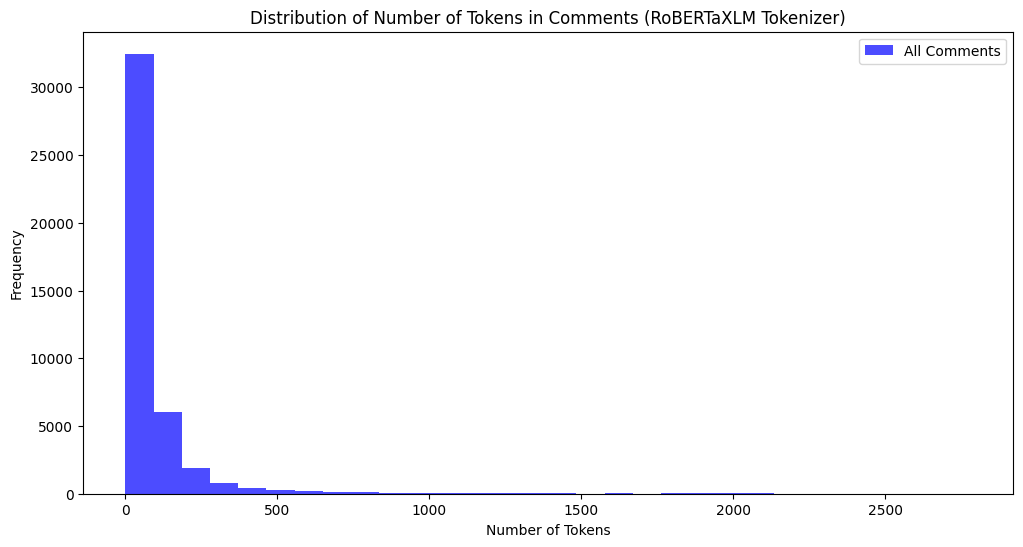

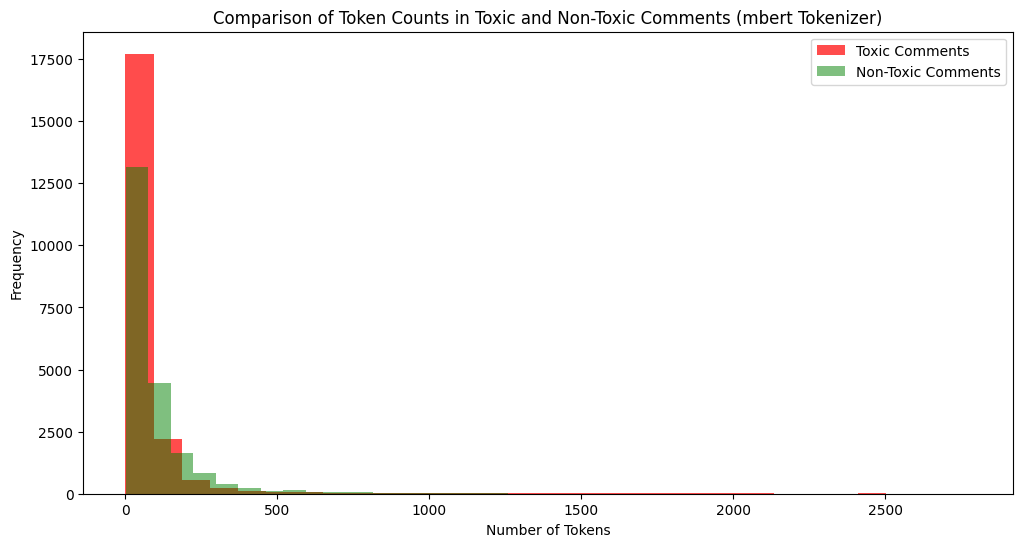

In [21]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Add a column for the number of tokens
balanced_df['num_tokens'] = balanced_df['comment_text'].apply(
    lambda x: len(tokenizer.tokenize(str(x)))
)

# Plot the distribution of tokens for all comments
plt.figure(figsize=(12, 6))
plt.hist(balanced_df['num_tokens'], bins=30, color='blue', alpha=0.7, label='All Comments')
plt.title('Distribution of Number of Tokens in Comments (RoBERTaXLM Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Separate toxic and non-toxic for comparison
plt.figure(figsize=(12, 6))
plt.hist(balanced_df[balanced_df['toxic'] == 1]['num_tokens'], bins=30, color='red', alpha=0.7, label='Toxic Comments')
plt.hist(balanced_df[balanced_df['toxic'] == 0]['num_tokens'], bins=30, color='green', alpha=0.5, label='Non-Toxic Comments')
plt.title('Comparison of Token Counts in Toxic and Non-Toxic Comments (mbert Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend() a
plt.show()





## distribution in validation dataset
Token distribution in the validation dataset was analyzed using the XLM-RoBERTa tokenizer. Histograms were plotted for overall, toxic, and non-toxic comments to compare text length variations. This ensured comments remained within the 512-token limit for model compatibility.

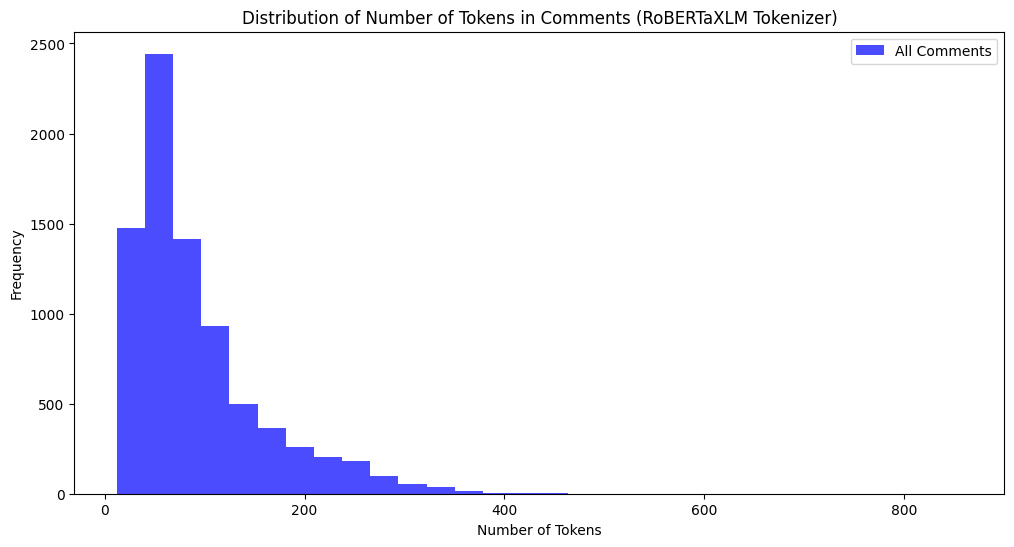

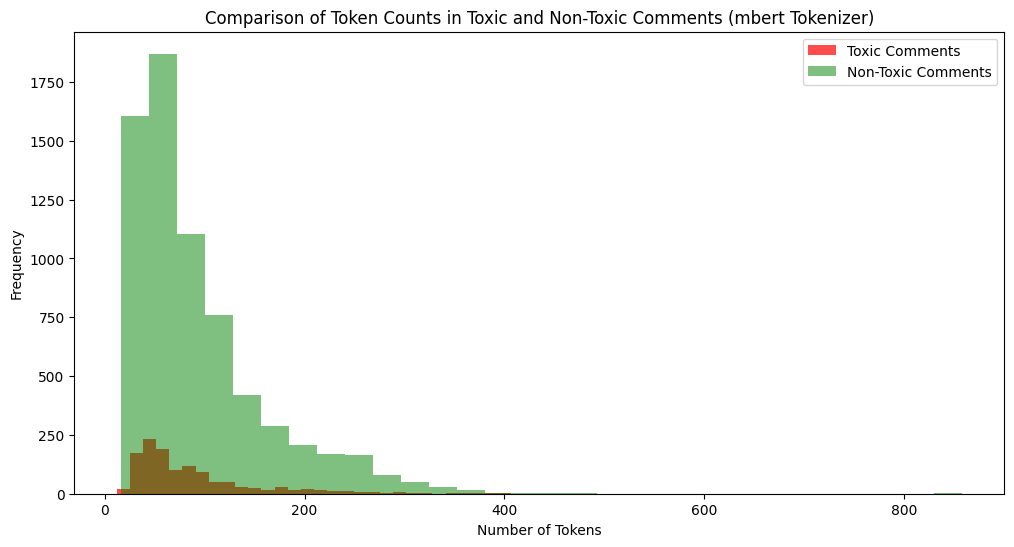

In [22]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

# Add a column for the number of tokens
validation_df['num_tokens'] = validation_df['comment_text'].apply(
    lambda x: len(tokenizer.tokenize(str(x)))
)

# Plot the distribution of tokens for all comments
plt.figure(figsize=(12, 6))
plt.hist(validation_df['num_tokens'], bins=30, color='blue', alpha=0.7, label='All Comments')
plt.title('Distribution of Number of Tokens in Comments (RoBERTaXLM Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Separate toxic and non-toxic for comparison
plt.figure(figsize=(12, 6))
plt.hist(validation_df[validation_df['toxic'] == 1]['num_tokens'], bins=30, color='red', alpha=0.7, label='Toxic Comments')
plt.hist(validation_df[validation_df['toxic'] == 0]['num_tokens'], bins=30, color='green', alpha=0.5, label='Non-Toxic Comments')
plt.title('Comparison of Token Counts in Toxic and Non-Toxic Comments (mbert Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## filtering
Comments exceeding 510 tokens were filtered out to comply with the model’s 512-token limit. The dataset size before and after filtering was recorded, along with the number of removed comments.

In [23]:

# Add a column for the number of tokens
balanced_df['num_tokens'] = balanced_df['comment_text'].apply(
    lambda x: len(tokenizer.tokenize(str(x)))
)

# Filter out comments with tokens exceeding 510
filtered_df = balanced_df[balanced_df['num_tokens'] <= 510]

# Print statistics
print(f"Original dataset size: {len(balanced_df)}")
print(f"Filtered dataset size: {len(filtered_df)}")
print(f"Number of comments removed: {len(balanced_df) - len(filtered_df)}")

Original dataset size: 42768
Filtered dataset size: 41696
Number of comments removed: 1072


## simillarily for validation dataset

In [24]:

# Add a column for the number of tokens
validation_df['num_tokens'] = validation_df['comment_text'].apply(
    lambda x: len(tokenizer.tokenize(str(x)))
)

# Filter out comments with tokens exceeding 510
vald_filtered_df = validation_df[validation_df['num_tokens'] <= 510]

# Print statistics
print(f"vald Original dataset size: {len(validation_df)}")
print(f"vald Filtered dataset size: {len(vald_filtered_df)}")
print(f"vald Number of comments removed: {len(validation_df) - len(vald_filtered_df)}")

vald Original dataset size: 8000
vald Filtered dataset size: 7999
vald Number of comments removed: 1


##  PyTorch dataset 
A PyTorch dataset class was created to tokenize comments, pad/truncate to 512 tokens, and return inputs as tensors for model training.

In [25]:
class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'  # returns PyTorch tensors
        )

        # Convert batch dimension to single examples
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)

        return item

## training validation testing dataset
Training and validation datasets were created using the ToxicDataset class.

In [26]:
train_texts = filtered_df["comment_text"].tolist()
train_labels = filtered_df["toxic"].tolist()

val_texts = validation_df["comment_text"].tolist()
val_labels = validation_df["toxic"].tolist()

train_dataset = ToxicDataset(train_texts, train_labels, tokenizer, max_length=512)
val_dataset   = ToxicDataset(val_texts,   val_labels,   tokenizer, max_length=512)


## Metrics define
A metrics function was defined to evaluate model performance. It computes accuracy and ROC-AUC, converting logits to probabilities using softmax. Predictions are derived using argmax, and scores are calculated using accuracy_score and roc_auc_score.

In [27]:
def compute_metrics(eval_pred):
    """
    Returns a dictionary of evaluation metrics. 
    Calculates both accuracy and ROC-AUC.
    """
    logits, labels = eval_pred
    # Convert logits to probabilities via softmax
    probs = softmax(logits, axis=1)
    
    # Predicted class is argmax
    preds = np.argmax(probs, axis=1)

    acc = accuracy_score(labels, preds)
    # For roc_auc, we use the probability of the "positive" class (index = 1)
    roc = roc_auc_score(labels, probs[:, 1])
    
    return {
        "accuracy": acc,
        "roc_auc": roc
    }

## Training arguments 
The XLM-RoBERTa model was initialized for binary classification. Training arguments defined batch size, learning rate, and evaluation strategy. The Trainer API handled training and evaluation efficiently.

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)


training_args = TrainingArguments(
    output_dir="./xlmr_model",
    evaluation_strategy="epoch",       # Evaluate every epoch
    save_strategy="epoch",             # Save checkpoint every epoch
    num_train_epochs=2,                # You can adjust this
    per_device_train_batch_size=8,     # Adjust based on GPU memory
    per_device_eval_batch_size=8,      # Same as above
    logging_dir="./logs",              # Directory for logs
    logging_steps=100,                 
    load_best_model_at_end=True,       # Loads best model found during eval
    metric_for_best_model="roc_auc",   # Choose metric to select best model
    greater_is_better=True,            # Higher metric is better
    seed=42,
    learning_rate=2e-5,
    report_to=["none"]
)

# =========================================
# 9. Initialize Trainer
# =========================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-cef6c7e7771c>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Training the model
The model was trained using the Trainer API, optimizing weights based on the defined training arguments and dataset.

In [29]:
trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc
1,0.190200,0.330726,0.873000,0.911624
2,0.180200,0.461748,0.868625,0.906466


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=5212, training_loss=0.20642901114198856, metrics={'train_runtime': 5964.9505, 'train_samples_per_second': 13.98, 'train_steps_per_second': 0.874, 'total_flos': 2.194135712858112e+16, 'train_loss': 0.20642901114198856, 'epoch': 2.0})

## Evaluation of the model

In [30]:
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Evaluation Results: {'eval_loss': 0.3307260274887085, 'eval_accuracy': 0.873, 'eval_roc_auc': 0.9116240948229277, 'eval_runtime': 166.3025, 'eval_samples_per_second': 48.105, 'eval_steps_per_second': 3.007, 'epoch': 2.0}


The model achieved an evaluation loss of 0.3307, with an accuracy of 87.3% and an ROC-AUC of 0.9116, indicating strong classification performance. The evaluation ran in 166.3 seconds, processing 48.1 samples per second over 2 epochs.

## saving the model

In [31]:
trainer.save_model("./xlmr_lowlrate")
